In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras

import spacy

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')


In [2]:
RANDOM_STATE = 7

# Data review

In [3]:
df = pd.read_csv("data/Aboutlabeled.csv")

In [4]:
df.head()

,Text,Label,ID,Offsets,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Funding Circle was created with a big idea:,None,article_00000.pre.xmi:001,[],NaN,NaN,NaN
1,To revolutionize the outdated banking system a...,About,article_00000.pre.xmi:002,[{u'text': u'revolutionize the outdated bankin...,NaN,NaN,NaN
2,"Thousands of loans later, we've helped busines...",About,article_00000.pre.xmi:003,"[{u'text': u'we', u'endOffset': 28, u'beginOff...",NaN,NaN,NaN
3,We've taken this progress global.,About,article_00000.pre.xmi:004,"[{u'text': u'We', u'endOffset': 2, u'beginOffs...",NaN,NaN,NaN
4,Funding Circle is the world's leading marketpl...,About,article_00000.pre.xmi:005,"[{u'text': u'Funding Circle', u'endOffset': 14...",NaN,NaN,NaN


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16721 entries, 0 to 16720
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        16721 non-null  object
 1   Label       16707 non-null  object
 2   ID          16720 non-null  object
 3   Offsets     16721 non-null  object
 4   Unnamed: 4  69 non-null     object
 5   Unnamed: 5  11 non-null     object
 6   Unnamed: 6  4 non-null      object
dtypes: object(7)
memory usage: 914.6+ KB


### Clear data

#### Check for non-empty data in columns 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'

In [36]:
df['Unnamed: 4'][pd.isnull(df['Unnamed: 4']) == False]

678                                                     []
1122                                                    []
1128                                                    []
2255                             article_00110.pre.xmi:008
2648     [{u'text': u'ionStar', u'endOffset': 28, u'beg...
                               ...                        
15644                            article_00753.pre.xmi:016
15660                                                About
16148                                                   []
16370                                                About
16437                                                   []
Name: Unnamed: 4, Length: 69, dtype: object

In [37]:
df['Unnamed: 5'][pd.isnull(df['Unnamed: 5']) == False]

2255                                                    []
2865     [{u'text': u'Our', u'endOffset': 3, u'beginOff...
3662                             article_00183.pre.xmi:012
7297     [{u'text': u"Always focus on doing the 'right ...
8997                                                    []
12975    [{u'text': 'We', u'endOffset': 2, u'beginOffse...
14316                            article_00691.pre.xmi:005
14974                                                   []
15644    [{u'text': 'mobile-messaging', u'endOffset': 9...
15660                            article_00753.pre.xmi:032
16370                            article_00783.pre.xmi:012
Name: Unnamed: 5, dtype: object

In [38]:
df['Unnamed: 6'][pd.isnull(df['Unnamed: 6']) == False]

3662                                                    []
14316                                                   []
15660    [{u'text': 'mobile-messaging', u'endOffset': 9...
16370    [{u'text': u'Our', u'endOffset': 3, u'beginOff...
Name: Unnamed: 6, dtype: object

#### *As we can see, this is just wrong data*

#### Delete unnecessary columns

In [5]:
df = df.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'],  axis=1)

In [40]:
df.head()

,Text,Label,ID,Offsets
0,Funding Circle was created with a big idea:,None,article_00000.pre.xmi:001,[]
1,To revolutionize the outdated banking system a...,About,article_00000.pre.xmi:002,[{u'text': u'revolutionize the outdated bankin...
2,"Thousands of loans later, we've helped busines...",About,article_00000.pre.xmi:003,"[{u'text': u'we', u'endOffset': 28, u'beginOff..."
3,We've taken this progress global.,About,article_00000.pre.xmi:004,"[{u'text': u'We', u'endOffset': 2, u'beginOffs..."
4,Funding Circle is the world's leading marketpl...,About,article_00000.pre.xmi:005,"[{u'text': u'Funding Circle', u'endOffset': 14..."


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16721 entries, 0 to 16720
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     16721 non-null  object
 1   Label    16707 non-null  object
 2   ID       16720 non-null  object
 3   Offsets  16721 non-null  object
dtypes: object(4)
memory usage: 522.7+ KB


#### Delete rows with NaN or incorrect Labels

In [6]:
# number of incorrect labels
incorrect_labels_index = df[(df['Label'] != 'About') & (df['Label'] != 'None')].index
len(incorrect_labels_index)

69

In [7]:
# delete empty and incorrect rows
df.drop(index=incorrect_labels_index, axis=0, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16652 entries, 0 to 16720
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     16652 non-null  object
 1   Label    16652 non-null  object
 2   ID       16652 non-null  object
 3   Offsets  16652 non-null  object
dtypes: object(4)
memory usage: 650.5+ KB


### Distribution of labels

None     14785
About     1867
Name: Label, dtype: int64

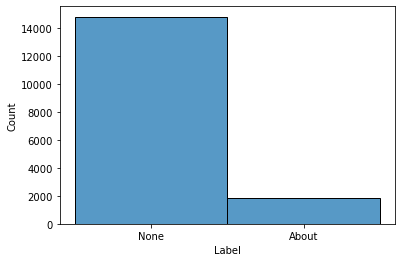

In [16]:
sns.histplot(df['Label'])
df['Label'].value_counts()

# Baseline

### Bag-of-words

In [9]:
%%time
# Create bag-of-words vectorizer
count_vect = CountVectorizer()
count_vect.fit(df['Text'])

# Create vectorized sentensec
X_count_vect = count_vect.transform(df['Text'])
# Create y vector
y = df['Label'].map({'None': 0, 'About': 1})

CPU times: user 441 ms, sys: 10.5 ms, total: 451 ms
Wall time: 453 ms


In [47]:
%%time
#Build a 2-dimensional representation
X_embedded_c_vect = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(X_count_vect)

CPU times: user 13min 6s, sys: 23.7 s, total: 13min 29s
Wall time: 2min 14s


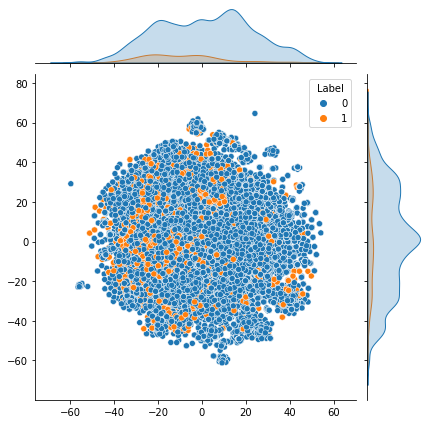

In [48]:
sns.jointplot(x=X_embedded_c_vect[:, 0], y=X_embedded_c_vect[:, 1], hue=y)

#### *We can see, that the bag of words method doesn't have enough information, but the target labels are concentrated at the left side*

### Print main metrics function

In [37]:
# Function for print main metrics for prediction
def print_scores(y_val, y_pred, regulator=0.5):
    
    # Rounding the prediction with the select threshold
    th_y_pred = np.where(np.array(y_pred) > regulator, 1, 0)
    
    # Print scores
    acc_score = accuracy_score(y_val, th_y_pred)
    pr_score, re_score, f_score, _ = precision_recall_fscore_support(y_val, 
                                                                     th_y_pred, 
                                                                     average='binary')
    print(f"Accuracy score: {round(acc_score, 3)}")
    print(f"Precision score: {round(pr_score, 3)}")
    print(f"Recall score: {round(re_score, 3)}")
    print(f"F-score: {round(f_score, 3)}")
    
    # Calculate F1-Score for the thresholds
    f_scores = list()
    threshold = np.linspace(0, 1, 100)
    
    for step in threshold:
        th_y_pred = np.where(np.array(y_pred) > step, 1, 0)
        _, _, f_score, _ = precision_recall_fscore_support(y_val,
                                                           th_y_pred,
                                                           average='binary')
        f_scores.append(f_score)
    
    # Drawing F1-Score for the thresholds
    ax = sns.lineplot(x=threshold, y=f_scores)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1-Score')
    
    # Print the best F1-Score and the appropriate threshold
    print(f"\nMax F1-Score: {round(np.max(f_scores), 3)} (threshold: {round(threshold[np.argmax(f_scores)], 3)})\n")
        
    
    

#### Split data

In [50]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_count_vect, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

#### *Score if we will be predict only "None" label:*

Accuracy score: 0.884
Precision score: 0.0
Recall score: 0.0
F-score: 0.0

Max F1-Score: 0.0 (threshold: 0.0)



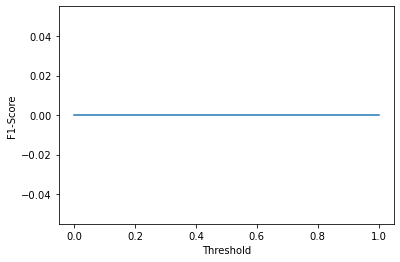

In [51]:
# predict only "None" labels
y_pred = [0] * 4996

# scores for only "None" labels
print_scores(y_val, y_pred)

#### *We can see, that the accuracy score is quite high, but the really important scores are at zero*

### Linear Regression

In [52]:
%%time
# Create and fit LinearRegression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

CPU times: user 4min 36s, sys: 15.8 s, total: 4min 51s
Wall time: 45.4 s


LinearRegression()

Accuracy score: 0.657
Precision score: 0.169
Recall score: 0.5
F-score: 0.252

Max F1-Score: 0.256 (threshold: 0.636)



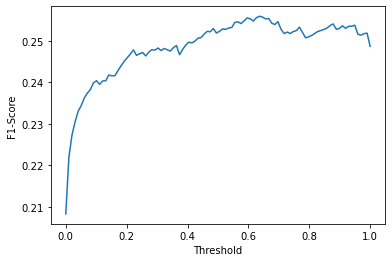

In [53]:
# Linear Regression estimate
print_scores(y_val, lr_model.predict(X_val))

#### *Linear regression has a very low estimates. So, will build a simple neural network*

### Plot history function

In [38]:
# Function for drawing a history graphs from NNs
def plot_history_nn(history, combined_keys=None, calculate_f1_score=False):
    """
    Takes a history object from NN and plots all metrics.
    
    Parameters
    ----------
    history : history.history object what NN.fit returns
    combined_keys : array_like
        If neen to combine several metrics in one window.
        Metrics contained in the same list like:
        combined_keys=[[metric1, metric2, metric3], [metric4]] 
        will be drawn in one window (metric1-3)
    calculate_f1_score : Boolean
        Will calculate the F1-Score for each epoch.
        For "combined_keys" use the "val_f1_score" key
    """
    # Calculate F1-Score for all epochs if calculate_f1_score == True
    if calculate_f1_score:
        precision = np.array(history['val_precision'])
        recall = np.array(history['val_recall'])
        history['val_f1_score'] = 2 * ((precision * recall) / (precision + recall))
        # Replace np.nan to zero
        history['val_f1_score'] = np.nan_to_num(history['val_f1_score'])
    
    # Check if uses without combined_keys
    if not combined_keys:
        keys = list(history.keys())
        # Raise error if number of metrics not a pair
        if len(keys) % 2 != 0:
            raise ValueError("History object doesn't have a pair number of keys")
        x = list(range(len(history[keys[0]])))
    else:
        keys = list(combined_keys)
        # Check for each element of combined_keys that it is a list
        for key in keys:
            if type(key) != list:
                raise ValueError(f"Element:'{key}' is not a list")
        x = list(range(len(history[keys[0][0]])))
    
    # Prepare windows
    rows  = int(np.ceil(len(keys) / 2))
    _, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    
    # Draw metrics
    for i, key in enumerate(keys):
        indx=np.unravel_index(i, shape=axs.shape)
        
        if combined_keys:
            for inter_key in key:
                sns.lineplot(x=x, y=history[inter_key], ax=axs[indx], label=inter_key)
        else:
            sns.lineplot(x=x, y=history[key], ax=axs[indx], label=key)
        axs[indx].set_xlabel("Epoch")
    
    # Print the best results for each metric
    for key in history.keys():
        # Save min/max results
        min_res = str(round(np.min(history[key]), 3))
        max_res = str(round(np.max(history[key]), 3))
        # Find the appropriate epoch for min/max results
        epoch_min_res = np.argmin(history[key]) + 1
        epoch_max_res = np.argmax(history[key]) + 1
        
        indent = ' ' * (15 - len(key))
        
        print(f"{key}: {indent} min-{min_res}({epoch_min_res} epoch), \t max-{max_res}({epoch_max_res} epoch)")



# Dense neural network

In [55]:
X_train.shape[1]

17802

In [56]:
# Create NN model
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1], )))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model.compile(optimizer='rmsprop', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', 'Precision', 'Recall'])
nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                284848    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 285,137
Trainable params: 285,137
Non-trainable params: 0
_________________________________________________________________


In [59]:
# model training
model_history_nn = nn_model.fit(X_train, 
                                y_train.values, 
                                batch_size=128, 
                                epochs=10, 
                                validation_data=(X_val, y_val.values))

Epoch 1/10
92/92 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 0.9861 - precision: 0.9476 - recall: 0.9255 - val_loss: 0.4963 - val_accuracy: 0.8987 - val_precision: 0.6000 - val_recall: 0.3737
Epoch 2/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0332 - accuracy: 0.9882 - precision: 0.9564 - recall: 0.9356 - val_loss: 0.5388 - val_accuracy: 0.8979 - val_precision: 0.5924 - val_recall: 0.3772
Epoch 3/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9918 - precision: 0.9693 - recall: 0.9566 - val_loss: 0.5921 - val_accuracy: 0.8959 - val_precision: 0.5843 - val_recall: 0.3478
Epoch 4/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0205 - accuracy: 0.9941 - precision: 0.9803 - recall: 0.9659 - val_loss: 0.6232 - val_accuracy: 0.8937 - val_precision: 0.5617 - val_recall: 0.3702
Epoch 5/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9954 - precision: 0

In [60]:
model_history_nn.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

loss:             min-0.004(10 epoch), 	 max-0.042(1 epoch)
accuracy:         min-0.986(1 epoch), 	 max-0.999(10 epoch)
precision:        min-0.948(1 epoch), 	 max-0.998(10 epoch)
recall:           min-0.926(1 epoch), 	 max-0.994(10 epoch)
val_loss:         min-0.496(1 epoch), 	 max-0.954(10 epoch)
val_accuracy:     min-0.89(10 epoch), 	 max-0.899(1 epoch)
val_precision:    min-0.537(10 epoch), 	 max-0.6(1 epoch)
val_recall:       min-0.344(8 epoch), 	 max-0.377(2 epoch)
val_f1_score:     min-0.422(8 epoch), 	 max-0.461(2 epoch)


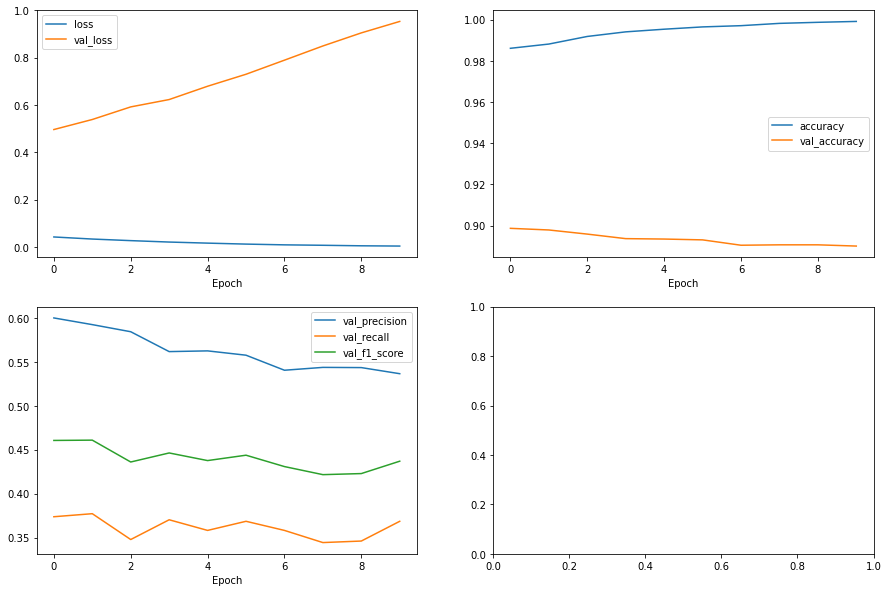

In [61]:
# Results for first NN
plot_history_nn(model_history_nn.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'], 
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)

Accuracy score: 0.89
Precision score: 0.537
Recall score: 0.369
F-score: 0.437

Max F1-Score: 0.462 (threshold: 0.202)



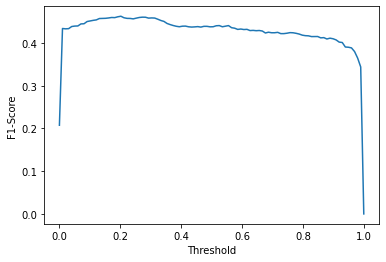

In [62]:
y_pred_nn = nn_model.predict(X_val)
print_scores(y_val, y_pred_nn)

#### *Train a new neural network only with 7 epochs*

In [64]:
# Build a model
nn_model_7ep = keras.models.Sequential()
nn_model_7ep.add(keras.layers.Dense(16, activation='relu', input_shape=(X_count_vect.shape[1], )))
nn_model_7ep.add(keras.layers.Dense(16, activation='relu'))
nn_model_7ep.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model_7ep.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy', 'Precision', 'Recall'])

# Model training
model_history_nn_7ep = nn_model_7ep.fit(X_train, 
                                        y_train.values, 
                                        batch_size=128, 
                                        epochs=7, 
                                        validation_data=(X_val, y_val.values))

Epoch 1/7
92/92 [==============================] - 1s 8ms/step - loss: 0.5377 - accuracy: 0.8868 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3492 - val_accuracy: 0.8843 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/7
92/92 [==============================] - 0s 3ms/step - loss: 0.2902 - accuracy: 0.8872 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2698 - val_accuracy: 0.8843 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/7
92/92 [==============================] - 0s 3ms/step - loss: 0.1984 - accuracy: 0.9017 - precision: 0.6788 - recall: 0.1490 - val_loss: 0.2761 - val_accuracy: 0.9037 - val_precision: 0.6678 - val_recall: 0.3339
Epoch 4/7
92/92 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.9427 - precision: 0.7861 - recall: 0.6413 - val_loss: 0.2864 - val_accuracy: 0.8989 - val_precision: 0.5824 - val_recall: 0.4464
Epoch 5/7
92/92 [==============================] - 0s 3ms/step - loss: 0.1360 - accu

loss:             min-0.096(7 epoch), 	 max-0.464(1 epoch)
accuracy:         min-0.888(1 epoch), 	 max-0.968(7 epoch)
precision:        min-0.0(1 epoch), 	 max-0.861(7 epoch)
recall:           min-0.0(1 epoch), 	 max-0.848(7 epoch)
val_loss:         min-0.27(2 epoch), 	 max-0.383(7 epoch)
val_accuracy:     min-0.884(1 epoch), 	 max-0.904(3 epoch)
val_precision:    min-0.0(1 epoch), 	 max-0.668(3 epoch)
val_recall:       min-0.0(1 epoch), 	 max-0.455(7 epoch)
val_f1_score:     min-0.0(1 epoch), 	 max-0.505(4 epoch)


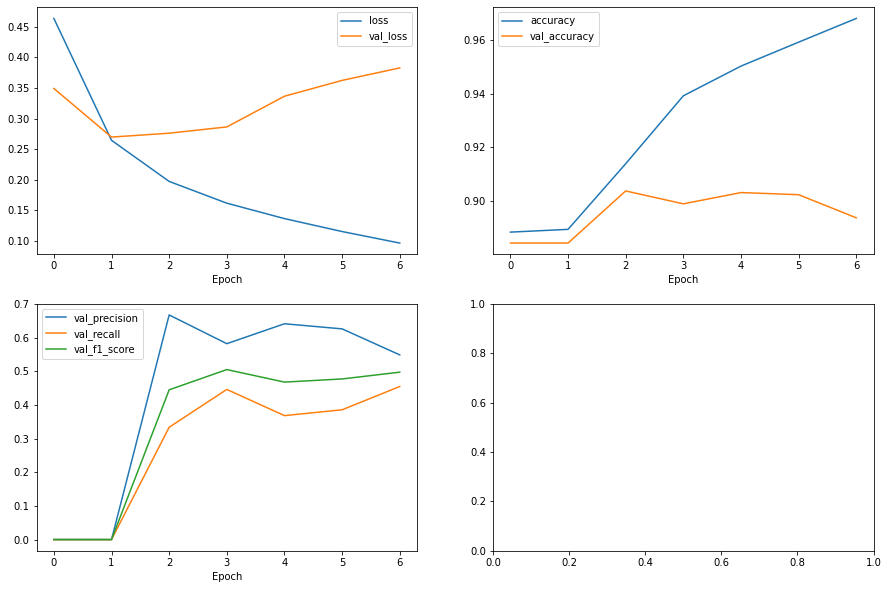

In [65]:

# Results for first NN
plot_history_nn(model_history_nn_7ep.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'], 
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)

Accuracy score: 0.894
Precision score: 0.549
Recall score: 0.455
F-score: 0.498

Max F1-Score: 0.5 (threshold: 0.404)



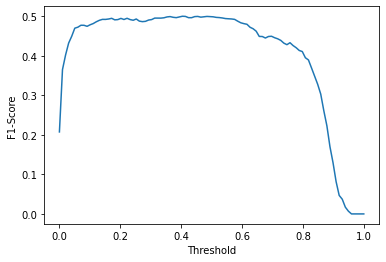

In [66]:
# Model estimation
y_pred_nn_7ep = nn_model_7ep.predict(X_val)
print_scores(y_val, y_pred_nn_7ep)

#### *Gets a high precision score but a low recall score while a low threshold values*

#### *Train a new neural network with labels weight*

In [67]:
# Build a model
nn_model_lab_we = keras.models.Sequential()
nn_model_lab_we.add(keras.layers.Dense(16, activation='relu', input_shape=(X_count_vect.shape[1], )))
nn_model_lab_we.add(keras.layers.Dense(16, activation='relu'))
nn_model_lab_we.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model_lab_we.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'Precision', 'Recall'])

# model training
history_nn_lab_we = nn_model_lab_we.fit(X_train, 
                                        y_train.values, 
                                        batch_size=128, 
                                        epochs=3,
                                        class_weight={0: 0.1, 1:0.9},
                                        validation_data=(X_val, y_val.values))

Epoch 1/3
92/92 [==============================] - 1s 6ms/step - loss: 0.1221 - accuracy: 0.3304 - precision: 0.1448 - recall: 0.9727 - val_loss: 0.7072 - val_accuracy: 0.6894 - val_precision: 0.2615 - val_recall: 0.9239
Epoch 2/3
92/92 [==============================] - 0s 4ms/step - loss: 0.0907 - accuracy: 0.7628 - precision: 0.3155 - recall: 0.9364 - val_loss: 0.5314 - val_accuracy: 0.8381 - val_precision: 0.3920 - val_recall: 0.7249
Epoch 3/3
92/92 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.8725 - precision: 0.4704 - recall: 0.9264 - val_loss: 0.4929 - val_accuracy: 0.8307 - val_precision: 0.3793 - val_recall: 0.7284


loss:             min-0.067(3 epoch), 	 max-0.114(1 epoch)
accuracy:         min-0.475(1 epoch), 	 max-0.874(3 epoch)
precision:        min-0.17(1 epoch), 	 max-0.464(3 epoch)
recall:           min-0.908(3 epoch), 	 max-0.961(1 epoch)
val_loss:         min-0.493(3 epoch), 	 max-0.707(1 epoch)
val_accuracy:     min-0.689(1 epoch), 	 max-0.838(2 epoch)
val_precision:    min-0.262(1 epoch), 	 max-0.392(2 epoch)
val_recall:       min-0.725(2 epoch), 	 max-0.924(1 epoch)
val_f1_score:     min-0.408(1 epoch), 	 max-0.509(2 epoch)


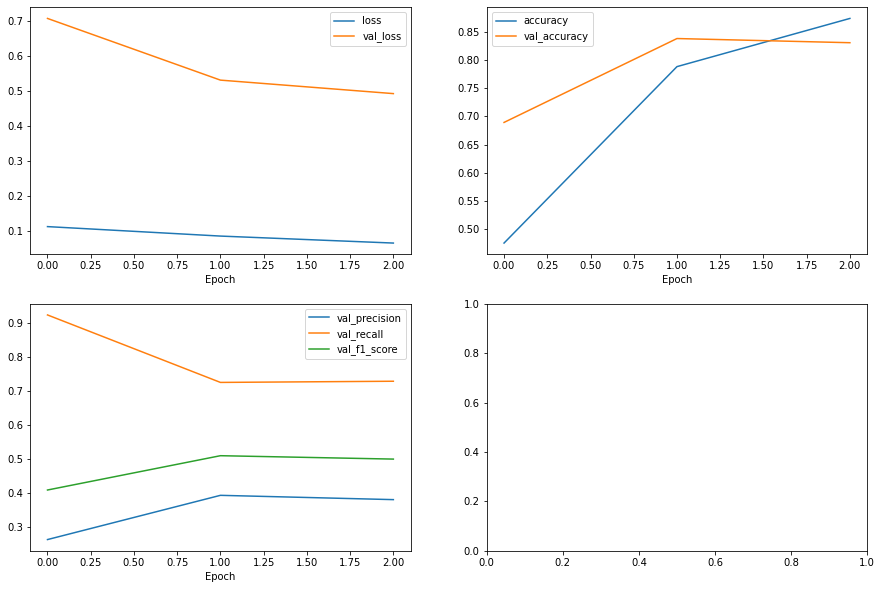

In [68]:
# Results for NN with labels weight
plot_history_nn(history_nn_lab_we.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'],
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True) 

Accuracy score: 0.831
Precision score: 0.379
Recall score: 0.728
F-score: 0.499

Max F1-Score: 0.539 (threshold: 0.747)



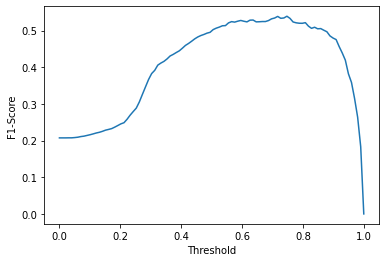

In [69]:
# Model estimation
y_pred_nn_lab_we = nn_model_lab_we.predict(X_val)
print_scores(y_val, y_pred_nn_lab_we)

#### *Get a low precision score but a high recall score while a high threshold values. <br> Also, NN models with dropout layers was tested, but this didn't help to improve the model*

# TF-IDF vectorizer

In [70]:
%%time

#Create TF-IDF vectorizer
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(df['Text'])

#Create vectorized sentensec
X_tfidf = tfidf_vect.transform(df['Text'])

CPU times: user 436 ms, sys: 7.32 ms, total: 443 ms
Wall time: 446 ms


CPU times: user 13min 30s, sys: 30 s, total: 14min
Wall time: 2min 11s


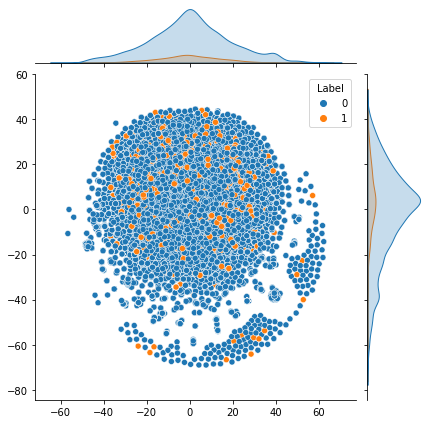

In [71]:
%%time
#Build a 2-dimensional representation
X_embedded_tfidf = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(X_tfidf)
sns.jointplot(x=X_embedded_tfidf[:, 0], y=X_embedded_tfidf[:, 1], hue=y)

#### *We can see an interesting picture, but also not enough useful information*

### Split data

In [72]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

### Linear regression

Accuracy score: 0.643
Precision score: 0.166
Recall score: 0.521
F-score: 0.252

Max F1-Score: 0.257 (threshold: 0.798)

CPU times: user 4min 49s, sys: 9.65 s, total: 4min 59s
Wall time: 40.7 s


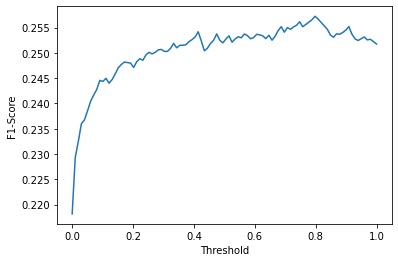

In [73]:
%%time

# Create and fit LinearRegression model
lr_model_tfidf = LinearRegression()
lr_model_tfidf.fit(X_train, y_train)

# Linear Regression estimate
print_scores(y_val, lr_model_tfidf.predict(X_val))

#### *As we can see, the linear regression again has low scores, but little bit better than previous version with bag-of-words*

### Neural network

In [97]:
%%time

# Build a model
nn_model_tfidf = keras.models.Sequential()
nn_model_tfidf.add(keras.layers.Dense(16, activation='relu', input_shape=(X_tfidf.shape[1], )))
nn_model_tfidf.add(keras.layers.Dense(16, activation='relu'))
nn_model_tfidf.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model_tfidf.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'Precision', 'Recall'])

# model training
history_nn_tfidf = nn_model_tfidf.fit(X_train.toarray(),
                                      y_train.values,
                                      batch_size=512,
                                      epochs=10,
                                      validation_data=(X_val.toarray(), y_val.values))

Epoch 1/10
23/23 [==============================] - 3s 75ms/step - loss: 0.6580 - accuracy: 0.8628 - precision: 0.1316 - recall: 0.0419 - val_loss: 0.5725 - val_accuracy: 0.8843 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
23/23 [==============================] - 1s 26ms/step - loss: 0.5410 - accuracy: 0.8938 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4800 - val_accuracy: 0.8843 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
23/23 [==============================] - 1s 23ms/step - loss: 0.4511 - accuracy: 0.8876 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4127 - val_accuracy: 0.8843 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
23/23 [==============================] - 1s 23ms/step - loss: 0.3766 - accuracy: 0.8947 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3737 - val_accuracy: 0.8843 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
23/23 [==============================] - 

loss:             min-0.178(10 epoch), 	 max-0.63(1 epoch)
accuracy:         min-0.882(1 epoch), 	 max-0.919(10 epoch)
precision:        min-0.0(2 epoch), 	 max-1.0(8 epoch)
recall:           min-0.0(2 epoch), 	 max-0.283(10 epoch)
val_loss:         min-0.26(10 epoch), 	 max-0.573(1 epoch)
val_accuracy:     min-0.884(1 epoch), 	 max-0.898(10 epoch)
val_precision:    min-0.0(1 epoch), 	 max-0.88(9 epoch)
val_recall:       min-0.0(1 epoch), 	 max-0.161(10 epoch)
val_f1_score:     min-0.0(1 epoch), 	 max-0.267(10 epoch)


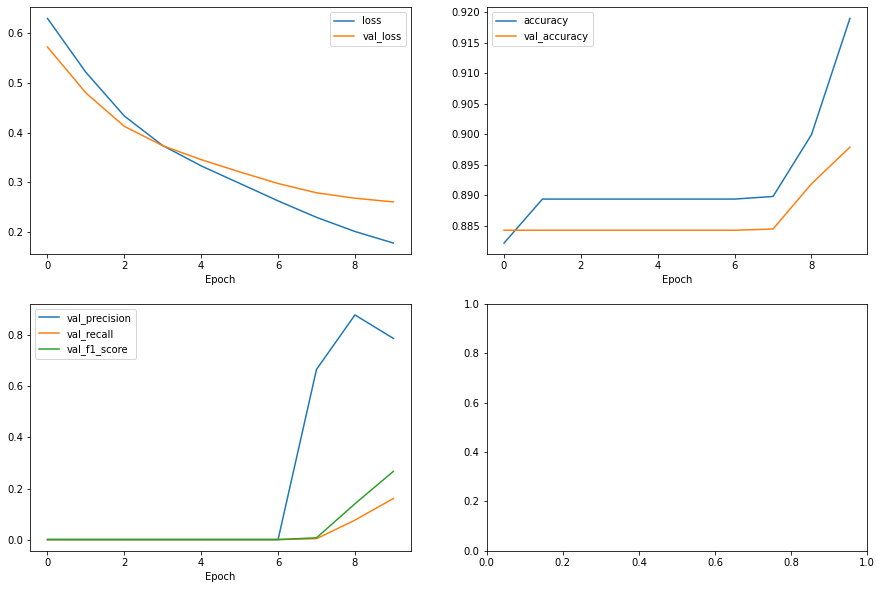

In [98]:
# Results NN for TF-IDF
plot_history_nn(history_nn_tfidf.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'],
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)

Accuracy score: 0.898
Precision score: 0.788
Recall score: 0.161
F-score: 0.267

Max F1-Score: 0.511 (threshold: 0.162)



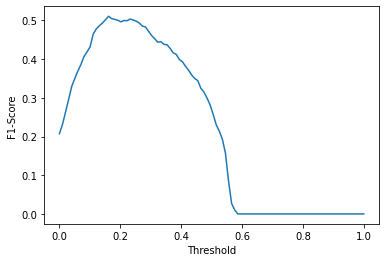

In [101]:
# Model estimation
y_pred_nn_tfidf = nn_model_tfidf.predict(X_val.toarray())
print_scores(y_val, y_pred_nn_tfidf)

#### *The TF-IDF vectors shows worse results than privius version with Bag-of-words*

# Class balancing and weight

In [102]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_count_vect, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

### NN with class_weight

In [103]:
# Calculate the weight of the class
class_weight = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y)
class_weight = {0: class_weight[0], 1: class_weight[1]}
class_weight

{0: 0.5631383158606696, 1: 4.459560792715586}

In [104]:
%%time

# Build a model
nn_model_tfidf_cw = keras.models.Sequential()
nn_model_tfidf_cw.add(keras.layers.Dense(128, activation='relu', input_shape=(X_tfidf.shape[1], )))
nn_model_tfidf_cw.add(keras.layers.Dropout(0.5))
nn_model_tfidf_cw.add(keras.layers.Dense(128, activation='relu'))
nn_model_tfidf_cw.add(keras.layers.Dropout(0.5))
nn_model_tfidf_cw.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model_tfidf_cw.compile(optimizer='rmsprop',
                          loss='binary_crossentropy',
                          metrics=['accuracy', 'Precision', 'Recall'])

# model training
history_nn_tfidf_cw = nn_model_tfidf_cw.fit(X_train,
                                            y_train.values,
                                            batch_size=128,
                                            epochs=10,
                                            class_weight=class_weight,
                                            validation_data=(X_val, y_val.values))

Epoch 1/10
92/92 [==============================] - 3s 16ms/step - loss: 0.6491 - accuracy: 0.6783 - precision: 0.1982 - recall: 0.6104 - val_loss: 0.5700 - val_accuracy: 0.7426 - val_precision: 0.2828 - val_recall: 0.7976
Epoch 2/10
92/92 [==============================] - 1s 12ms/step - loss: 0.4490 - accuracy: 0.8149 - precision: 0.3536 - recall: 0.8083 - val_loss: 0.5242 - val_accuracy: 0.7784 - val_precision: 0.3117 - val_recall: 0.7578
Epoch 3/10
92/92 [==============================] - 1s 11ms/step - loss: 0.3653 - accuracy: 0.8566 - precision: 0.4400 - recall: 0.8644 - val_loss: 0.4396 - val_accuracy: 0.8179 - val_precision: 0.3505 - val_recall: 0.6730
Epoch 4/10
92/92 [==============================] - 1s 11ms/step - loss: 0.2865 - accuracy: 0.8965 - precision: 0.5164 - recall: 0.8927 - val_loss: 0.4374 - val_accuracy: 0.8291 - val_precision: 0.3644 - val_recall: 0.6419
Epoch 5/10
92/92 [==============================] - 1s 10ms/step - loss: 0.2444 - accuracy: 0.9206 - precisi

loss:             min-0.084(10 epoch), 	 max-0.598(1 epoch)
accuracy:         min-0.722(1 epoch), 	 max-0.987(10 epoch)
precision:        min-0.24(1 epoch), 	 max-0.924(10 epoch)
recall:           min-0.699(1 epoch), 	 max-0.958(10 epoch)
val_loss:         min-0.397(6 epoch), 	 max-0.57(1 epoch)
val_accuracy:     min-0.743(1 epoch), 	 max-0.877(9 epoch)
val_precision:    min-0.283(1 epoch), 	 max-0.468(9 epoch)
val_recall:       min-0.474(10 epoch), 	 max-0.798(1 epoch)
val_f1_score:     min-0.418(1 epoch), 	 max-0.476(9 epoch)


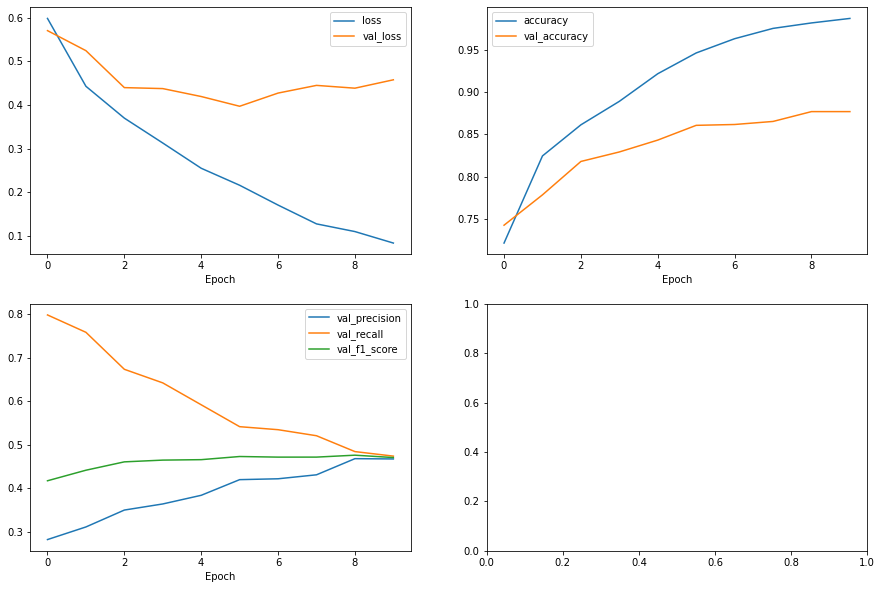

In [105]:
# Results NN with class_weight
plot_history_nn(history_nn_tfidf_cw.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'],
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)

Accuracy score: 0.877
Precision score: 0.468
Recall score: 0.474
F-score: 0.471

Max F1-Score: 0.472 (threshold: 0.505)



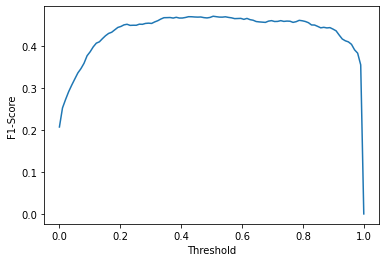

In [106]:
# Model estimation
y_pred_nn_tfidf_cw = nn_model_tfidf_cw.predict(X_val)
print_scores(y_val, y_pred_nn_tfidf_cw)

#### *The weight of the class does not improve the results enough*

### UnderSampling

In [107]:
pd.DataFrame(y_train).value_counts()

Label
0        10367
1         1289
dtype: int64

In [108]:
# Create UnderSampler and resample X, y train
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

In [109]:
pd.DataFrame(y_train_under).value_counts()

Label
0        1289
1        1289
dtype: int64

In [110]:
X_train_under.shape

(2578, 17802)

In [111]:
%%time

# Build a model
nn_model_under_samp = keras.models.Sequential()
nn_model_under_samp.add(keras.layers.Dense(32, activation='relu', input_shape=(X_tfidf.shape[1], )))
nn_model_under_samp.add(keras.layers.Dropout(0.5))
nn_model_under_samp.add(keras.layers.Dense(32, activation='relu'))
nn_model_under_samp.add(keras.layers.Dropout(0.5))
nn_model_under_samp.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model_under_samp.compile(optimizer='rmsprop',
                          loss='binary_crossentropy',
                          metrics=['accuracy', 'Precision', 'Recall'])

# model training
history_nn_under_samp = nn_model_under_samp.fit(X_train_under,
                                                y_train_under.values,
                                                batch_size=128,
                                                epochs=10,
                                                validation_data=(X_val, y_val.values))

Epoch 1/10
21/21 [==============================] - 3s 25ms/step - loss: 0.6869 - accuracy: 0.5806 - precision: 0.5866 - recall: 0.5375 - val_loss: 0.6968 - val_accuracy: 0.5528 - val_precision: 0.2019 - val_recall: 0.9706
Epoch 2/10
21/21 [==============================] - 0s 8ms/step - loss: 0.6371 - accuracy: 0.7287 - precision: 0.6968 - recall: 0.8155 - val_loss: 0.6573 - val_accuracy: 0.6805 - val_precision: 0.2578 - val_recall: 0.9377
Epoch 3/10
21/21 [==============================] - 0s 8ms/step - loss: 0.5723 - accuracy: 0.7883 - precision: 0.7846 - recall: 0.8095 - val_loss: 0.5716 - val_accuracy: 0.7832 - val_precision: 0.3274 - val_recall: 0.8287
Epoch 4/10
21/21 [==============================] - 0s 8ms/step - loss: 0.5056 - accuracy: 0.8341 - precision: 0.8396 - recall: 0.8263 - val_loss: 0.5254 - val_accuracy: 0.7918 - val_precision: 0.3369 - val_recall: 0.8253
Epoch 5/10
21/21 [==============================] - 0s 8ms/step - loss: 0.4438 - accuracy: 0.8431 - precision: 

loss:             min-0.191(10 epoch), 	 max-0.68(1 epoch)
accuracy:         min-0.614(1 epoch), 	 max-0.947(10 epoch)
precision:        min-0.613(1 epoch), 	 max-0.945(10 epoch)
recall:           min-0.621(1 epoch), 	 max-0.95(10 epoch)
val_loss:         min-0.433(7 epoch), 	 max-0.697(1 epoch)
val_accuracy:     min-0.553(1 epoch), 	 max-0.818(7 epoch)
val_precision:    min-0.202(1 epoch), 	 max-0.369(7 epoch)
val_recall:       min-0.803(8 epoch), 	 max-0.971(1 epoch)
val_f1_score:     min-0.334(1 epoch), 	 max-0.51(10 epoch)


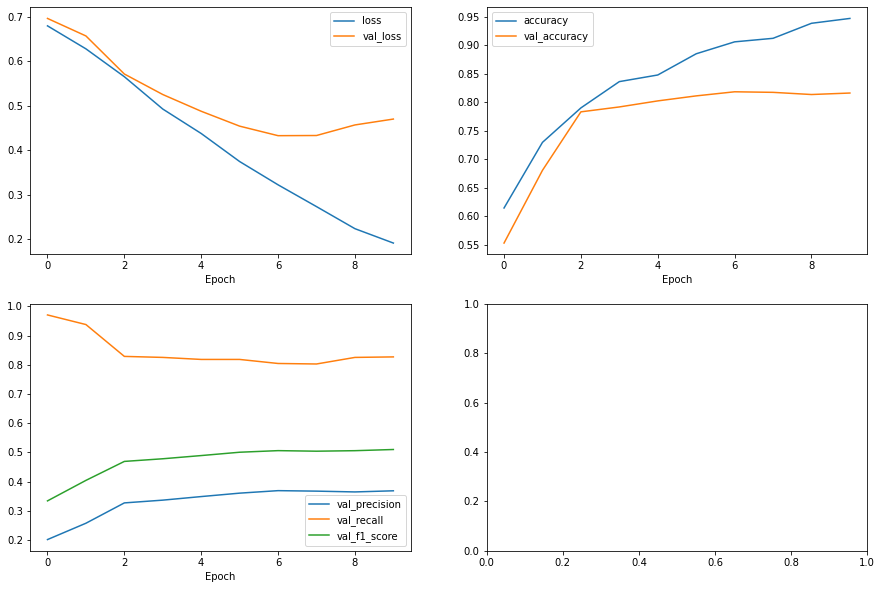

In [112]:
# Results NN for UnderSampling
plot_history_nn(history_nn_under_samp.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'],
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)

Accuracy score: 0.816
Precision score: 0.369
Recall score: 0.827
F-score: 0.51

Max F1-Score: 0.545 (threshold: 0.879)



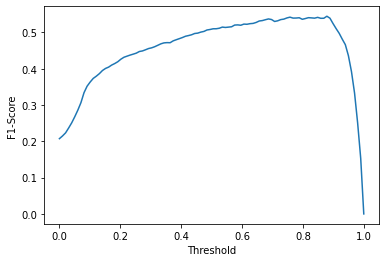

In [113]:
# Model estimation
y_pred_nn_under_samp = nn_model_under_samp.predict(X_val)
print_scores(y_val, y_pred_nn_under_samp)

#### *We can see, that class balance improves scores*

### OverSampling

In [114]:
# Create OverSampler and resample X, y train
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [115]:
pd.DataFrame(y_train_over).value_counts()

Label
0        10367
1        10367
dtype: int64

In [116]:
%%time

# Build a model
nn_model_over_samp = keras.models.Sequential()
nn_model_over_samp.add(keras.layers.Dense(64, activation='relu', input_shape=(X_tfidf.shape[1], )))
nn_model_over_samp.add(keras.layers.Dropout(0.5))
nn_model_over_samp.add(keras.layers.Dense(64, activation='relu'))
nn_model_over_samp.add(keras.layers.Dropout(0.5))
nn_model_over_samp.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model_over_samp.compile(optimizer='rmsprop',
                          loss='binary_crossentropy',
                          metrics=['accuracy', 'Precision', 'Recall'])

# model training
history_nn_over_samp = nn_model_over_samp.fit(X_train_over,
                                                y_train_over.values,
                                                batch_size=64,
                                                epochs=10,
                                                validation_data=(X_val, y_val.values))

Epoch 1/10
324/324 [==============================] - 3s 7ms/step - loss: 0.5006 - accuracy: 0.7705 - precision: 0.7306 - recall: 0.8809 - val_loss: 0.2915 - val_accuracy: 0.8907 - val_precision: 0.5213 - val_recall: 0.6765
Epoch 2/10
324/324 [==============================] - 2s 6ms/step - loss: 0.1729 - accuracy: 0.9414 - precision: 0.9315 - recall: 0.9532 - val_loss: 0.3521 - val_accuracy: 0.9059 - val_precision: 0.6055 - val_recall: 0.5363
Epoch 3/10
324/324 [==============================] - 2s 6ms/step - loss: 0.1064 - accuracy: 0.9692 - precision: 0.9619 - recall: 0.9771 - val_loss: 0.4541 - val_accuracy: 0.9023 - val_precision: 0.5930 - val_recall: 0.4965
Epoch 4/10
324/324 [==============================] - 2s 6ms/step - loss: 0.0730 - accuracy: 0.9797 - precision: 0.9720 - recall: 0.9881 - val_loss: 0.6304 - val_accuracy: 0.9049 - val_precision: 0.6253 - val_recall: 0.4446
Epoch 5/10
324/324 [==============================] - 2s 6ms/step - loss: 0.0533 - accuracy: 0.9866 - pr

loss:             min-0.021(10 epoch), 	 max-0.375(1 epoch)
accuracy:         min-0.85(1 epoch), 	 max-0.995(10 epoch)
precision:        min-0.82(1 epoch), 	 max-0.992(10 epoch)
recall:           min-0.896(1 epoch), 	 max-0.999(9 epoch)
val_loss:         min-0.291(1 epoch), 	 max-1.547(10 epoch)
val_accuracy:     min-0.891(1 epoch), 	 max-0.908(7 epoch)
val_precision:    min-0.521(1 epoch), 	 max-0.673(8 epoch)
val_recall:       min-0.384(10 epoch), 	 max-0.676(1 epoch)
val_f1_score:     min-0.486(10 epoch), 	 max-0.589(1 epoch)


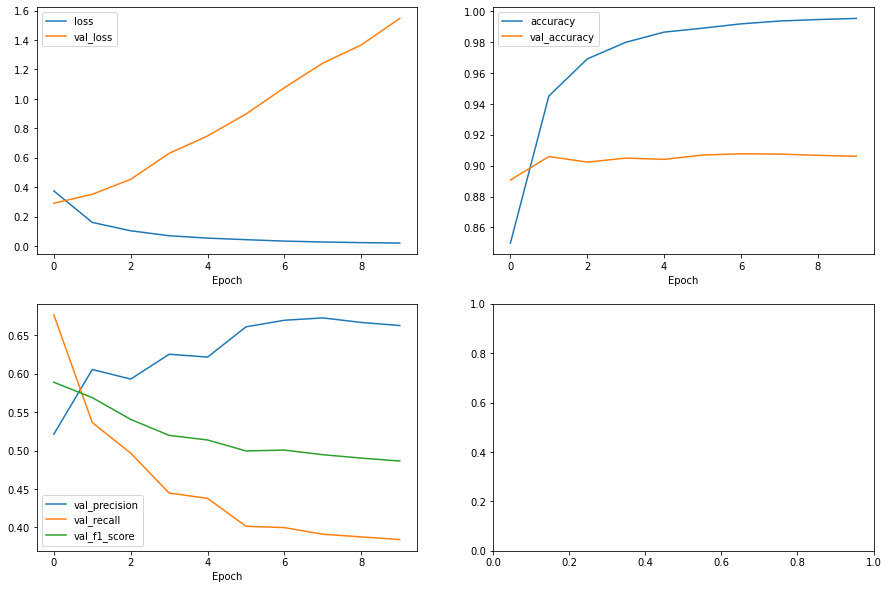

In [117]:
# Results NN for OverSampling
plot_history_nn(history_nn_over_samp.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'],
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)

Accuracy score: 0.906
Precision score: 0.663
Recall score: 0.384
F-score: 0.486

Max F1-Score: 0.528 (threshold: 0.01)



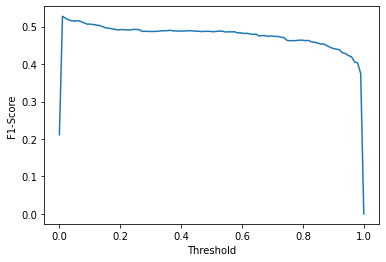

In [118]:
# Model estimation
y_pred_nn_over_samp = nn_model_over_samp.predict(X_val)
print_scores(y_val, y_pred_nn_over_samp)

#### *OverSampling also has better results than just imbalance classes<br>Will try the SMOTE method*

### SMOTE

In [119]:
# Create SMOTE and resample X, y train
smote = SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [120]:
pd.DataFrame(y_train_smote).value_counts()

Label
0        10367
1        10367
dtype: int64

In [121]:
%%time

# Build a model
nn_model_smote = keras.models.Sequential()
nn_model_smote.add(keras.layers.Dense(64, activation='relu', input_shape=(X_tfidf.shape[1], )))
nn_model_over_samp.add(keras.layers.Dropout(0.5))
nn_model_smote.add(keras.layers.Dense(64, activation='relu'))
nn_model_over_samp.add(keras.layers.Dropout(0.5))
nn_model_smote.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model_smote.compile(optimizer='rmsprop',
                          loss='binary_crossentropy',
                          metrics=['accuracy', 'Precision', 'Recall'])

# model training
history_nn_smote = nn_model_smote.fit(X_train_smote,
                                        y_train_smote.values,
                                        batch_size=256,
                                        epochs=10,
                                        validation_data=(X_val, y_val.values))

Epoch 1/10
81/81 [==============================] - 2s 11ms/step - loss: 0.5477 - accuracy: 0.8033 - precision: 0.7842 - recall: 0.8475 - val_loss: 0.4419 - val_accuracy: 0.8329 - val_precision: 0.3237 - val_recall: 0.4083
Epoch 2/10
81/81 [==============================] - 1s 7ms/step - loss: 0.2626 - accuracy: 0.9185 - precision: 0.9024 - recall: 0.9385 - val_loss: 0.4712 - val_accuracy: 0.8251 - val_precision: 0.3164 - val_recall: 0.4412
Epoch 3/10
81/81 [==============================] - 1s 7ms/step - loss: 0.1792 - accuracy: 0.9491 - precision: 0.9372 - recall: 0.9643 - val_loss: 0.4744 - val_accuracy: 0.8421 - val_precision: 0.3446 - val_recall: 0.4048
Epoch 4/10
81/81 [==============================] - 1s 7ms/step - loss: 0.1228 - accuracy: 0.9647 - precision: 0.9543 - recall: 0.9754 - val_loss: 0.5369 - val_accuracy: 0.8411 - val_precision: 0.3200 - val_recall: 0.3322
Epoch 5/10
81/81 [==============================] - 1s 7ms/step - loss: 0.0887 - accuracy: 0.9739 - precision: 

loss:             min-0.028(10 epoch), 	 max-0.447(1 epoch)
accuracy:         min-0.857(1 epoch), 	 max-0.992(10 epoch)
precision:        min-0.835(1 epoch), 	 max-0.987(10 epoch)
recall:           min-0.889(1 epoch), 	 max-0.998(10 epoch)
val_loss:         min-0.442(1 epoch), 	 max-1.33(10 epoch)
val_accuracy:     min-0.825(2 epoch), 	 max-0.846(9 epoch)
val_precision:    min-0.316(2 epoch), 	 max-0.345(3 epoch)
val_recall:       min-0.32(5 epoch), 	 max-0.441(2 epoch)
val_f1_score:     min-0.321(5 epoch), 	 max-0.372(3 epoch)


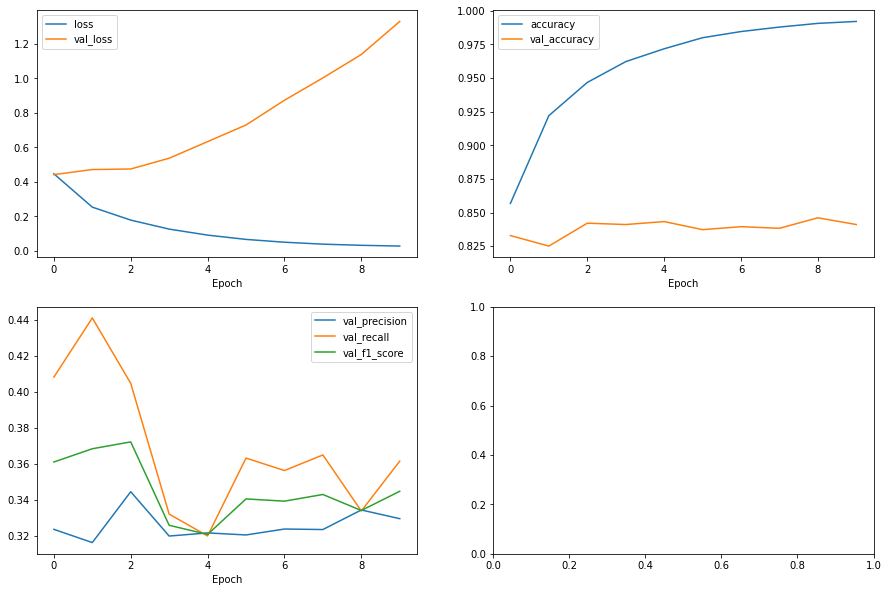

In [122]:
# Results NN for SMOTE
plot_history_nn(history_nn_smote.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'],
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)

#### *SMOTE balancing has worse results (F1-Score = 0.4) than other balancing methods*

# Embedding

### Tokenizer

In [26]:
maxlen = 100 # Max number of words in a sequence

# Split data
X_train_text, X_val_text, y_train, y_val = train_test_split(df['Text'], 
                                                            y, 
                                                            train_size = 0.7, 
                                                            shuffle=True,
                                                            random_state=RANDOM_STATE)

# Create a tokenizer and encode words for sequences of numbers
keras_tokenizer = keras.preprocessing.text.Tokenizer()
keras_tokenizer.fit_on_texts(X_train_text)

# Encode texts to sequences of numbers
X_train = keras_tokenizer.texts_to_sequences(X_train_text)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, 
                                                     padding='post', 
                                                     maxlen=maxlen)
X_val = keras_tokenizer.texts_to_sequences(X_val_text)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, 
                                                   padding='post',
                                                   maxlen=maxlen)


vocab_size = len(keras_tokenizer.word_index) + 1 # Vocabulary size and reserved index '0'

print(f"Vocabulary size: {vocab_size}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

Vocabulary size: 15805
X_train shape: (11656, 100)
X_val shape: (4996, 100)


In [124]:
y_train.value_counts()

0    10367
1     1289
Name: Label, dtype: int64

In [125]:
# OverSampling X_train, y_train
oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

1    10367
0    10367
Name: Label, dtype: int64

### Embedding layer

In [126]:
# Build a NN with a embedding layer
emb_model = keras.models.Sequential()
emb_model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                     output_dim=32,
                                     input_length=maxlen))
emb_model.add(keras.layers.Flatten())

# emb_model.add(keras.layers.SimpleRNN(32, input_shape=(10, 24)))
# emb_model.add(keras.layers.Dense(32, activation='relu'))
# nn_model_over_samp.add(keras.layers.Dropout(0.5))
# emb_model.add(keras.layers.Dense(32, activation='relu'))
# nn_model_over_samp.add(keras.layers.Dropout(0.5))
emb_model.add(keras.layers.Dense(1, activation='sigmoid'))
emb_model.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'Precision', 'Recall'])
emb_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           505760    
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 3201      
Total params: 508,961
Trainable params: 508,961
Non-trainable params: 0
_________________________________________________________________


In [127]:
history_nn_emb = emb_model.fit(X_train, 
                              y_train.values,
                              batch_size=64,
                              epochs=10,
                              validation_data=(X_val, y_val.values))

Epoch 1/10
324/324 [==============================] - 2s 3ms/step - loss: 0.5283 - accuracy: 0.7318 - precision: 0.7056 - recall: 0.7964 - val_loss: 0.3047 - val_accuracy: 0.8579 - val_precision: 0.4345 - val_recall: 0.7578
Epoch 2/10
324/324 [==============================] - 1s 2ms/step - loss: 0.2376 - accuracy: 0.9128 - precision: 0.8937 - recall: 0.9392 - val_loss: 0.2319 - val_accuracy: 0.9017 - val_precision: 0.5670 - val_recall: 0.6367
Epoch 3/10
324/324 [==============================] - 1s 2ms/step - loss: 0.1290 - accuracy: 0.9570 - precision: 0.9477 - recall: 0.9679 - val_loss: 0.2399 - val_accuracy: 0.9063 - val_precision: 0.5952 - val_recall: 0.5952
Epoch 4/10
324/324 [==============================] - 1s 2ms/step - loss: 0.0743 - accuracy: 0.9759 - precision: 0.9709 - recall: 0.9812 - val_loss: 0.2609 - val_accuracy: 0.9093 - val_precision: 0.6457 - val_recall: 0.4792
Epoch 5/10
324/324 [==============================] - 1s 2ms/step - loss: 0.0429 - accuracy: 0.9887 - pr

loss:             min-0.006(10 epoch), 	 max-0.435(1 epoch)
accuracy:         min-0.794(1 epoch), 	 max-0.998(10 epoch)
precision:        min-0.758(1 epoch), 	 max-0.998(10 epoch)
recall:           min-0.862(1 epoch), 	 max-0.999(10 epoch)
val_loss:         min-0.232(2 epoch), 	 max-0.553(9 epoch)
val_accuracy:     min-0.858(1 epoch), 	 max-0.909(4 epoch)
val_precision:    min-0.435(1 epoch), 	 max-0.689(7 epoch)
val_recall:       min-0.232(9 epoch), 	 max-0.758(1 epoch)
val_f1_score:     min-0.346(9 epoch), 	 max-0.6(2 epoch)


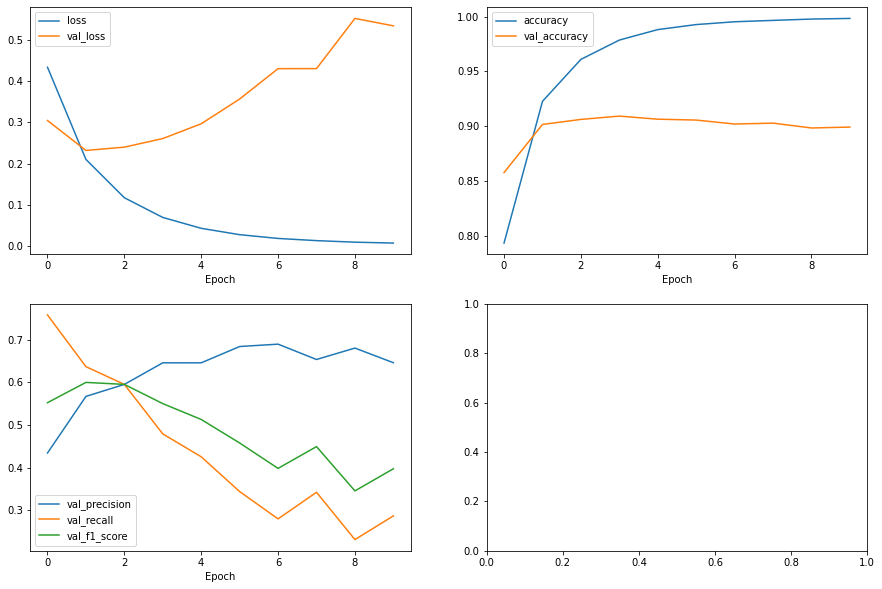

In [128]:
# Results NN for Embedding layer
plot_history_nn(history_nn_emb.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'],
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)

#### *For keras NNs this version has the best scores*

# Number of words in the text

In [20]:
# Counts the number of words

df['num_of_words'] = df['Text'].apply(lambda text: len(text.split()))

In [127]:
df.head()

,Text,Label,ID,Offsets,num_of_words
0,Funding Circle was created with a big idea:,None,article_00000.pre.xmi:001,[],8
1,To revolutionize the outdated banking system a...,About,article_00000.pre.xmi:002,[{u'text': u'revolutionize the outdated bankin...,13
2,"Thousands of loans later, we've helped busines...",About,article_00000.pre.xmi:003,"[{u'text': u'we', u'endOffset': 28, u'beginOff...",14
3,We've taken this progress global.,About,article_00000.pre.xmi:004,"[{u'text': u'We', u'endOffset': 2, u'beginOffs...",5
4,Funding Circle is the world's leading marketpl...,About,article_00000.pre.xmi:005,"[{u'text': u'Funding Circle', u'endOffset': 14...",30


### Distributions

In [128]:
df.groupby(['Label'])['num_of_words'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
About,1867.0,23.128013,9.419610,4.0,16.0,22.0,28.0,107.0
None,14785.0,13.237606,10.859506,1.0,4.0,11.0,20.0,118.0


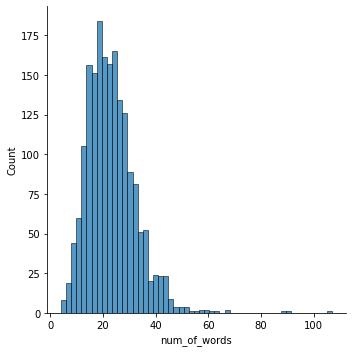

In [171]:
# Distribution for the 'About' label
ax = sns.displot(df['num_of_words'][df['Label'] == 'About'])

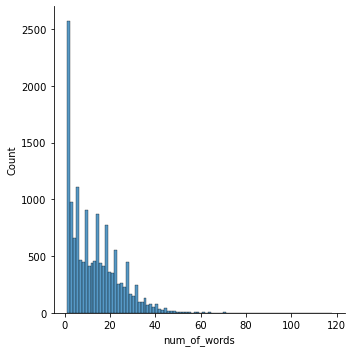

In [170]:
# Distribution for the 'None' label
ax = sns.displot(df['num_of_words'][df['Label'] == 'None'])

#### *We can see, that the number of words has different mean values for the labels.<br>Try for delete objects with less than 5 words for train data before preprocessing and deleting stop words*

In [50]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(df[['Text', 'num_of_words']], 
                                                    y, 
                                                    train_size = 0.8, 
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

In [147]:
# Number of objects with less than 5 words
len(X_train[X_train['num_of_words'] < 5])

3389

In [148]:
# Drop object where number of words less than 5

print(f"Number of words before: {len(X_train)}, y: {len(y_train)}")
X_train['y'] = y_train
X_train.drop(X_train[X_train['num_of_words'] < 5].index, axis = 0, inplace = True)
y_train = X_train['y']
print(f"Number of words after: {len(X_train)}, y: {len(y_train)}")

Number of words before: 13321, y: 13321
Number of words after: 9932, y: 9932


### Stop words and lemma

In [10]:
def preprocecing_text(text, return_lemma = False):
    X = df['Text']

    # Preprocessing data
    nlp = spacy.load('en_core_web_sm')

    # Remove spaces
    X = [string.strip() for string in text]

    # Preprocessing text
    docs = nlp.pipe(X)
    X = list()

    for doc in tqdm(docs):
        # Delete stop words
        words = [token for token in doc if not token.is_stop]

        if return_lemma:
            words = [token.lemma_ for token in words]
        else:
            words = [token.text for token in words]
            
        X.append(' '.join(words))
    
    return X

In [149]:
X_train = preprocecing_text(X_train['Text'])
X_val = preprocecing_text(X_val['Text'])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [137]:
len(X_train)

9932

In [150]:
maxlen = 100 # Max number of words in a sequence


# Create a tokenizer and encode words for sequences of numbers
keras_tokenizer = keras.preprocessing.text.Tokenizer()
keras_tokenizer.fit_on_texts(X_train)

# Encode texts to sequences of numbers
X_train = keras_tokenizer.texts_to_sequences(X_train)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, 
                                                     padding='post', 
                                                     maxlen=maxlen)
X_val = keras_tokenizer.texts_to_sequences(X_val)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, 
                                                   padding='post',
                                                   maxlen=maxlen)


vocab_size = len(keras_tokenizer.word_index) + 1 # Vocabulary size and reserved index '0'

print(f"Vocabulary size: {vocab_size}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

Vocabulary size: 15094
X_train shape: (9932, 100)
X_val shape: (3331, 100)


In [151]:
y_train.value_counts()

0    8460
1    1472
Name: y, dtype: int64

In [152]:
# OverSampling X_train, y_train
oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

0    8460
1    8460
Name: y, dtype: int64

### Embedding layer

In [153]:
# Build a NN with a embedding layer
emb_model_preptext = keras.models.Sequential()
emb_model_preptext.add(keras.layers.Embedding(input_dim=vocab_size, 
                                     output_dim=32,
                                     input_length=maxlen))
emb_model_preptext.add(keras.layers.Flatten())
emb_model_preptext.add(keras.layers.Dense(1, activation='sigmoid'))
emb_model_preptext.compile(optimizer='rmsprop',
                            loss='binary_crossentropy',
                            metrics=['accuracy', 'Precision', 'Recall'])
emb_model_preptext.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 32)           483008    
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3201      
Total params: 486,209
Trainable params: 486,209
Non-trainable params: 0
_________________________________________________________________


In [154]:
history_nn_preptext = emb_model_preptext.fit(X_train, 
                                              y_train.values,
                                              batch_size=64,
                                              epochs=10,
                                              validation_data=(X_val, y_val.values))

Epoch 1/10
265/265 [==============================] - 2s 3ms/step - loss: 0.6159 - accuracy: 0.6622 - precision: 0.6659 - recall: 0.6311 - val_loss: 0.3287 - val_accuracy: 0.8553 - val_precision: 0.4319 - val_recall: 0.7081
Epoch 2/10
265/265 [==============================] - 1s 2ms/step - loss: 0.3442 - accuracy: 0.8765 - precision: 0.8626 - recall: 0.8958 - val_loss: 0.2468 - val_accuracy: 0.8943 - val_precision: 0.5500 - val_recall: 0.5863
Epoch 3/10
265/265 [==============================] - 1s 2ms/step - loss: 0.1774 - accuracy: 0.9488 - precision: 0.9436 - recall: 0.9557 - val_loss: 0.2368 - val_accuracy: 0.9069 - val_precision: 0.6458 - val_recall: 0.4721
Epoch 4/10
265/265 [==============================] - 1s 2ms/step - loss: 0.1018 - accuracy: 0.9718 - precision: 0.9667 - recall: 0.9774 - val_loss: 0.2616 - val_accuracy: 0.9045 - val_precision: 0.6234 - val_recall: 0.4873
Epoch 5/10
265/265 [==============================] - 1s 2ms/step - loss: 0.0613 - accuracy: 0.9846 - pr

loss:             min-0.01(10 epoch), 	 max-0.548(1 epoch)
accuracy:         min-0.721(1 epoch), 	 max-0.997(10 epoch)
precision:        min-0.714(1 epoch), 	 max-0.997(10 epoch)
recall:           min-0.738(1 epoch), 	 max-0.997(10 epoch)
val_loss:         min-0.237(3 epoch), 	 max-0.449(10 epoch)
val_accuracy:     min-0.855(1 epoch), 	 max-0.907(3 epoch)
val_precision:    min-0.432(1 epoch), 	 max-0.668(6 epoch)
val_recall:       min-0.332(5 epoch), 	 max-0.708(1 epoch)
val_f1_score:     min-0.443(5 epoch), 	 max-0.568(2 epoch)


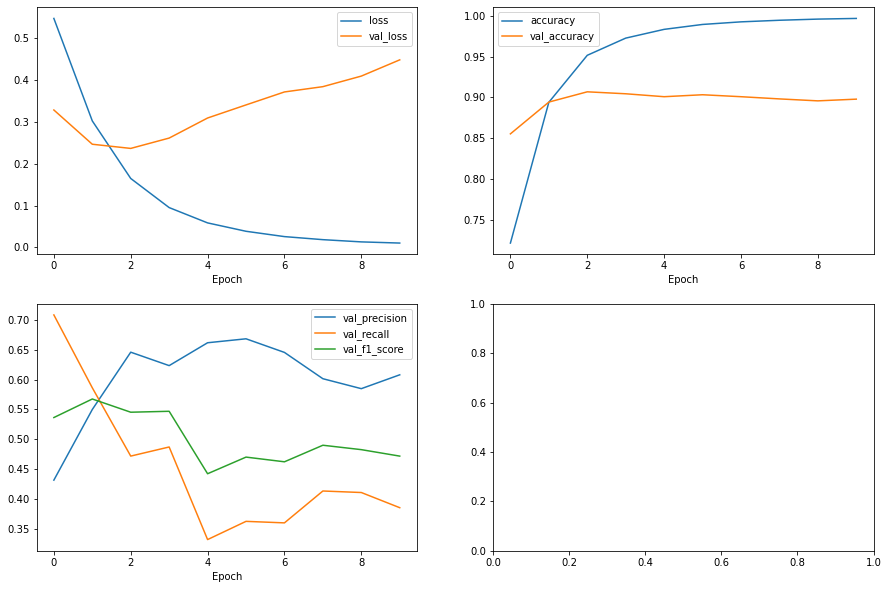

In [155]:
# Results NN for Embedding layer
plot_history_nn(history_nn_preptext.history, 
                combined_keys=[['loss', 'val_loss'], 
                               ['accuracy', 'val_accuracy'],
                               ['val_precision', 'val_recall', 'val_f1_score']],
                calculate_f1_score=True)